# Prestudy 1 | Implementation of a sample Unet architecture
June 2020,
Linus Meienberg

Implementation and training of a unet architecture following the tutorial provided under 
https://keras.io/examples/vision/oxford_pets_image_segmentation/

The Oxford pet image dataset contains images of various cat and dog breeds that are annotated by pixel masks of the same size and assign background, border and interior pixels. 

In [18]:
import utility
import numpy as np
import tensorflow as tf
from tensorflow import keras as k 
from importlib import reload  
import matplotlib.pyplot as plt


In [25]:
reload(utility)

<module 'utility' from 'c:\\Users\\Linus Meienberg\\Google Drive\\Janelia\\ImageSegmentation\\Unet1\\utility.py'>

In [26]:
k.backend.image_data_format() # Check that image tensors have format (batch, x, y, channels)

'channels_last'

In [27]:
# The dataset is downladed under 
# Locate the dataset files
# X:\lillvis\temp\linus\OxfordPetDataset
#base_dir = 'X:/lillvis/temp/linus/OxfordPetDataset/'
# C:\Users\Linus Meienberg\Google Drive\Janelia\ImageSegmentation
base_dir = 'C:/Users/Linus Meienberg/Google Drive/Janelia/ImageSegmentation'

images, masks = utility.get_path_lists(base_dir)

# shuffle the images
images, masks = utility.shuffle_path_lists(images, masks)

# set aside a validation fraction
val_samples = 1000
images_train = images[:-val_samples]
masks_train = masks[:-val_samples]
images_test = images[-val_samples:]
masks_test = masks[-val_samples:]


Number of samples: 7390


In [28]:
# Compute all valid input and output sizes for a net with a given number of blocks
blocks = 3
acceptable = [i for i in range(600) if utility.check_image_size(i,blocks)[0]]
print(acceptable)
# the reduction of the output size is a constant function of the number of blocks - compute once for a valid input size
print('output is {} pixels smaller'.format(acceptable[0]-utility.check_image_size(acceptable[0],blocks)[1]))

[92, 100, 108, 116, 124, 132, 140, 148, 156, 164, 172, 180, 188, 196, 204, 212, 220, 228, 236, 244, 252, 260, 268, 276, 284, 292, 300, 308, 316, 324, 332, 340, 348, 356, 364, 372, 380, 388, 396, 404, 412, 420, 428, 436, 444, 452, 460, 468, 476, 484, 492, 500, 508, 516, 524, 532, 540, 548, 556, 564, 572, 580, 588, 596]
output is 88.0 pixels smaller


In [29]:
utility.check_image_size(172,3)

(True, 84.0)

In [30]:
# Instantiate a Sequence object to stream the training and test set
batch_size = 32 #Batch size to use when evaluating the model
# Pick a valid combination of input and output sizes for the image and the mask from above
img_size = (172, 172)
mask_crop = 88//2 # Reduction of image size in one dimension as determined above divided by two

train_gen = utility.OxfordPets(
    batch_size, img_size, mask_crop, images_train, masks_train,
)
test_gen = utility.OxfordPets(batch_size, img_size, mask_crop, images_test, masks_test)

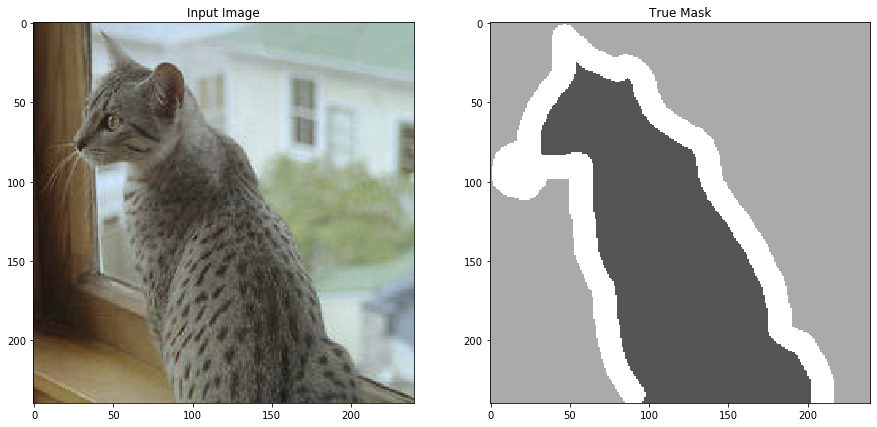

In [31]:
# Show one pair of an image and it's corresponding mask
utility.show_image_mask_pair(10, images_train, masks_train)


image shape (172, 172, 3) mask shape (84, 84, 1)


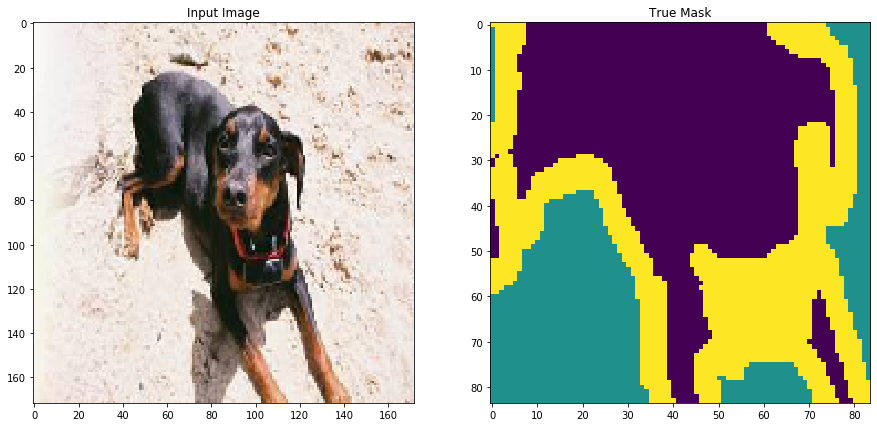

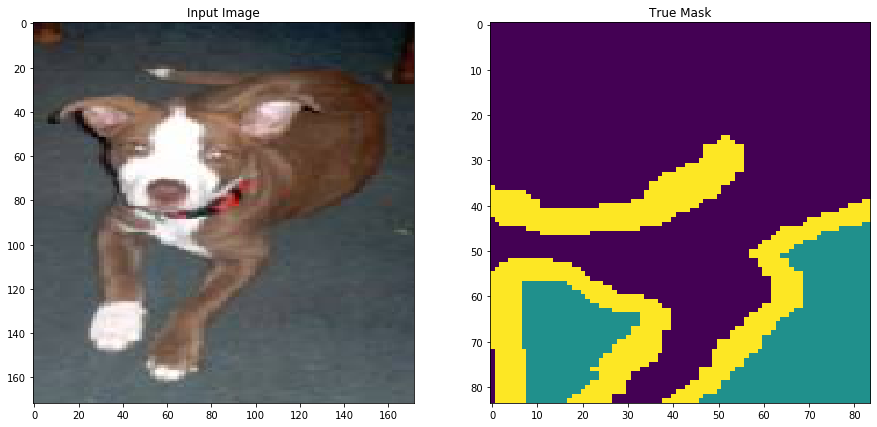

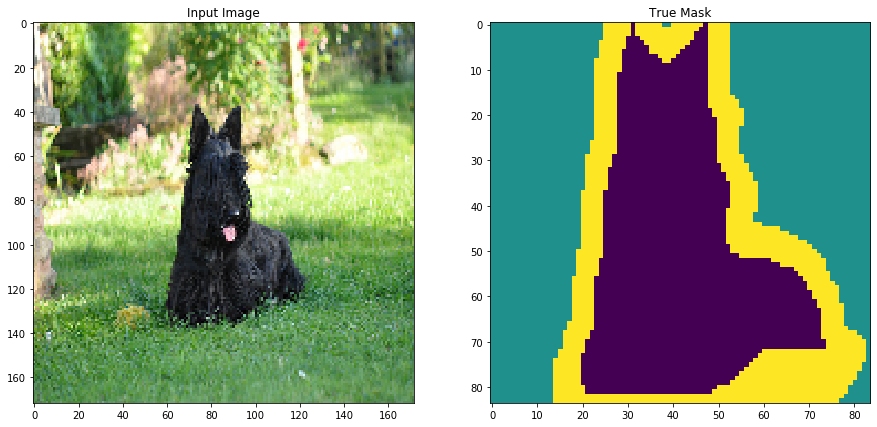

In [32]:
i, m = test_gen.__getitem__(0)
print('image shape {} mask shape {}'.format(i[0].shape,m[0].shape))
for image, mask in zip(i[0:3], m[0:3]):
    utility.display([image, mask])


In [97]:
img_size + (3,) #NOTE Dark Python tuple concatenation magic

(172, 172, 3)

In [33]:
initial_features = 64 # Number of filter maps to apply in the first downsampling block

def build_unet(n_blocks = 3):
    # Specify the model input (what kind of tensor to expect)
    input = k.Input(shape= img_size + (3,),
                    batch_size= batch_size,
                    name = 'InputImage')

    
    # DOWNSAMPLING PATH
    filters = initial_features
    x = input # Use x to store the topmost layer
    outputs = [] # List to store the skip connection output of each downsampling block

    for n in range(n_blocks):
        # Apply a downsampling block
        # First Convolution in block
        x = k.layers.Conv2D(filters=filters,
                            kernel_size=(3,3),
                            padding='valid',
                            activation='relu',
                            name='down_{}_conv_1'.format(n+1))(x)
        # Second convolution in block
        x = k.layers.Conv2D(filters=filters,
                            kernel_size=(3,3),
                            padding='valid',
                            activation='relu',
                            name='down_{}_conv_2'.format(n+1))(x)

        outputs.append(x) # Store intermediate outputs for skip connection
        
        # Max Pooling
        x = k.layers.MaxPool2D(pool_size=(2,2),
                            strides=(2,2),
                            name='down_{}_maxpool'.format(n+1))(x)
        
        # Update parameters for the next iteration
        filters *= 2 #double the number of filters

    # BRIDGE
    x = k.layers.Conv2D(filters=filters,
                            kernel_size=(3,3),
                            padding='valid',
                            activation='relu',
                            name='bridge_conv_1'.format(n+1))(x)
    x = k.layers.Conv2D(filters=filters,
                            kernel_size=(3,3),
                            padding='valid',
                            activation='relu',
                            name='bridge_conv_2'.format(n+1))(x)

    # UPSAMPLING PATH
    for n in range(n_blocks):
        # Apply an upsampling block
        # Update parameters for the next iteration
        filters = filters // 2 #half the number of filters (floor division)
        # Upconvolution 
        x = k.layers.Conv2DTranspose(filters=filters,
                                     kernel_size=(2,2),
                                     strides=(2,2),
                                     padding='valid',
                                     name='up_{}_upconvolution'.format(n+1))(x)

        # Crop Region from skip connection so that it matches the input from the lower layer
        target_shape = x.shape.as_list() # Shape of the output generated by the upsampling layer
        skip_input = outputs.pop() # Retrieve the last element appended to the list 
        given_shape = skip_input.shape.as_list() # Shape of the output used in skip connection
        # Difference of shapes divided by two for symmetric crop
        
        top_bottom_difference = (given_shape[1]-target_shape[1])
        left_right_difference = (given_shape[2]-target_shape[2])
        #print('tb {} lr {}'.format(top_bottom_difference,left_right_difference))
        crop = (top_bottom_difference//2,left_right_difference//2)
        #print(target_shape)
        #print(given_shape)
        #print(crop) 

        # Concatenate with cropped outputs in reverse order
        skip_input_cropped = k.layers.Cropping2D(cropping=crop,
                                                 name='up_{}_crop'.format(n+1))(skip_input)
        x = k.layers.Concatenate(name='up_{}_concat'.format(n+1))([x, skip_input_cropped])
        # First Convolution in block
        x = k.layers.Conv2D(filters=filters,
                            kernel_size=(3,3),
                            padding='valid',
                            activation='relu',
                            name='up_{}_conv_1'.format(n+1))(x)
        # Second convolution in block
        x = k.layers.Conv2D(filters=filters,
                            kernel_size=(3,3),
                            padding='valid',
                            activation='relu',
                            name='up_{}_conv_2'.format(n+1))(x)
        
    
    # CLASSIFICATION HEAD

    output = k.layers.Conv2D(kernel_size=(1,1),
                             filters = 3,
                             activation=None,
                             padding='valid',
                             name='class_logits')(x)

    model = k.Model(inputs=input, outputs= output)
    return model 

In [34]:
unet = build_unet(n_blocks=3)
unet.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputImage (InputLayer)         [(32, 172, 172, 3)]  0                                            
__________________________________________________________________________________________________
down_1_conv_1 (Conv2D)          (32, 170, 170, 64)   1792        InputImage[0][0]                 
__________________________________________________________________________________________________
down_1_conv_2 (Conv2D)          (32, 168, 168, 64)   36928       down_1_conv_1[0][0]              
__________________________________________________________________________________________________
down_1_maxpool (MaxPooling2D)   (32, 84, 84, 64)     0           down_1_conv_2[0][0]              
____________________________________________________________________________________________

In [35]:
unet.compile(optimizer='adam',
             # Mask Pixel value = sparese class label
             loss=k.losses.SparseCategoricalCrossentropy(from_logits=True) 
)

In [36]:
from IPython.display import clear_output

class DisplayCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        utility.show_predictions(unet, images_test, masks_test, num=2)
        print('\nSample Prediction after epoch{}'.format(epoch+1))


In [37]:
history = unet.fit(train_gen, epochs=20,
                   validation_data= test_gen,
                   callbacks=[DisplayCallback(),
                   k.callbacks.ModelCheckpoint('oxford_segmentation.h5', save_best_only=True)])

ValueError: Error when checking input: expected InputImage to have 4 dimensions, but got array with shape ()

In [85]:
train_gen.__getitem__(0)[0].shape

(32, 172, 172, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


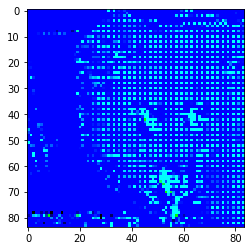

In [24]:
plt.imshow(unet(test_gen.__getitem__(0))[0])